In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import widgets
from matplotlib.widgets import Slider
import matplotlib.colors as mcolors

In [2]:
plt.rcParams['figure.figsize'] = [5, 3]

Cosine schedule of iDDPM:

$t \in [0,1]$<br>
$\displaystyle \alpha_t=\cos{(\pi t/2)}$

For variance preserving diffusion

$\displaystyle\sigma_t=\sqrt{1-\alpha^2_t}=\sin{(\pi t/2)}$

From VDM

$\displaystyle \text{SNR}(t)=\frac{\alpha^2_t}{\sigma^2_t};\; \log \text{SNR}(t)=2\log \alpha_t-2\log \sigma_t$

In [3]:
t = np.linspace(0,1, 10002)[1:-1]
alpha = np.cos(t*np.pi/2)
sigma = np.sin(t*np.pi/2)

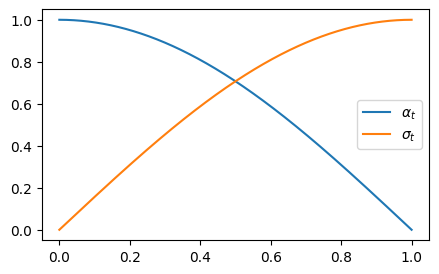

In [4]:
plt.plot(t,alpha, label=r'$\alpha_t$')
plt.plot(t,sigma, label=r'$\sigma_t$')
plt.legend();

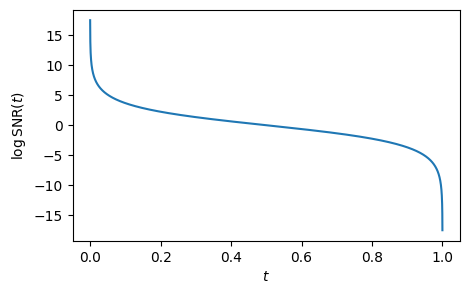

In [5]:
log_snr = - 2*np.log(np.tan(t*np.pi/2))
plt.plot(t,log_snr)
plt.xlabel(r'$t$')
plt.ylabel(r'$\log \text{SNR}(t)$');

Simple diffusion https://arxiv.org/abs/2301.11093 proposes using shifted noise shedule for higher resolutions to keep variance after downsampling unchanged.

$\displaystyle SNR(t)=\frac{\alpha_t^2}{\sigma^2_t}$

Since $z_t^{64\times 64}\sim \mathcal{N}(\alpha_t x^{64\times64},\sigma_t/2)$ after pooling we will compensate with SNR so that

$\displaystyle \text{SNR}^{d/s\times d/s}(t)=\text{SNR}^{d\times d}(t)\cdot s^2$

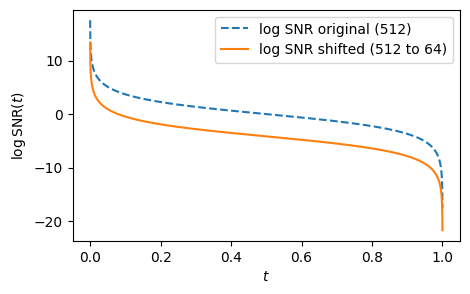

In [6]:
# for example we define default SNR for 64x64 images, then for 512x512 s = 1/8
s = 1/8
log_snr = - 2*np.log(np.tan(t*np.pi/2))
shifted_logsnr = log_snr + 2*np.log(s)
plt.plot(t,log_snr, linestyle='--',  label="log SNR original (512)")
plt.plot(t,shifted_logsnr,label="log SNR shifted (512 to 64)")
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$\log \text{SNR}(t)$');

## schedule as function of log SNR

In [7]:
def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

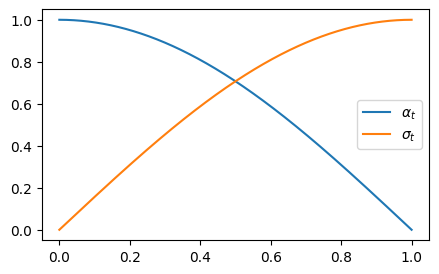

In [8]:
alpha = np.sqrt(sigmoid(log_snr))
sigma = np.sqrt(1-sigmoid(log_snr))
plt.plot(t,alpha, label=r'$\alpha_t$')
plt.plot(t,sigma, label=r'$\sigma_t$')
plt.legend();

In [9]:
def sheduler(log_snr):
    return np.sqrt(sigmoid(log_snr)), np.sqrt(1-sigmoid(log_snr))

### Shifted log SNR

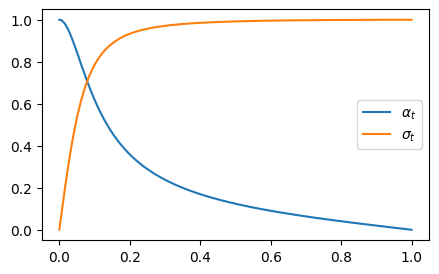

In [10]:
alpha, sigma = sheduler(shifted_logsnr)
plt.plot(t,alpha, label=r'$\alpha_t$')
plt.plot(t,sigma, label=r'$\sigma_t$')
plt.legend();

In [11]:
def shifted_logsnr(t, s):
    return - 2*np.log(np.tan(t*np.pi/2)) + 2*np.log(s)

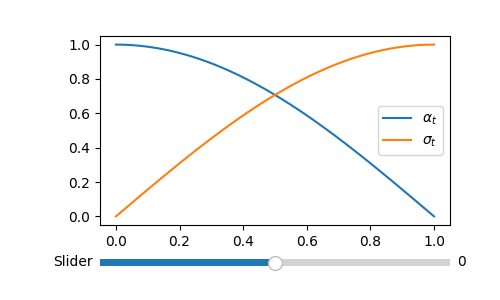

In [12]:
%matplotlib widget
fig, ax = plt.subplots(label='SNR')
fig.subplots_adjust(bottom=0.25,left=0.2)
ax: plt.Axes
alpha, sigma = sheduler(shifted_logsnr(t,1))
l1, = ax.plot(t,alpha, label=r'$\alpha_t$')
l2, = ax.plot(t,sigma, label=r'$\sigma_t$')

slider_ax = fig.add_axes([0.2, 0.1, 0.7, 0.05])
slider = Slider(slider_ax, 'Slider', -10, 10, valinit=0)

def update(val):
    s = 2**(val)
    alpha, sigma = sheduler(shifted_logsnr(t,s))
    l1.set_ydata(alpha);l2.set_ydata(sigma)
    fig.canvas.draw_idle()

slider.on_changed(update)

ax.legend()
plt.show();

## Interpolated scheduler
$\displaystyle \log \text{SNR}_\text{interpolate 32 -> 256} =t \log \text{SNR}^{512×512}_{\text{shift}\;256}(t) + (1 − t) \log \text{SNR}^{512×512}_{\text{shift}\; 32} (t)$

In [13]:
log_snr_lerp = shifted_logsnr(t, 256/512)*t + shifted_logsnr(t, 32/512)*(1-t)
alpha, sigma = sheduler(log_snr_lerp)

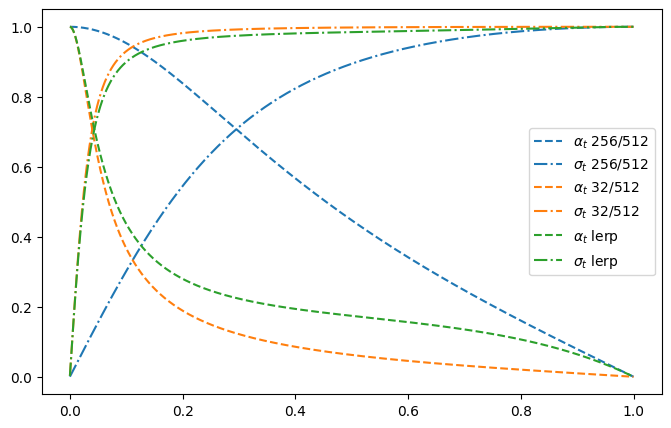

In [15]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(8,5))
a1,s1 = sheduler(shifted_logsnr(t, 256/512))
a2,s2 = sheduler(shifted_logsnr(t, 32/512))
ax.plot(t,a1, label=r'$\alpha_t$ 256/512', c = 'C0', linestyle='--')
ax.plot(t,s1, label=r'$\sigma_t$ 256/512', c = 'C0', linestyle='-.')
ax.plot(t,a2, label=r'$\alpha_t$ 32/512', c = 'C1', linestyle='--')
ax.plot(t,s2, label=r'$\sigma_t$ 32/512', c = 'C1', linestyle='-.')
ax.plot(t,alpha, label=r'$\alpha_t$ lerp', c = 'C2', linestyle='--')
ax.plot(t,sigma, label=r'$\sigma_t$ lerp', c = 'C2', linestyle='-.')

ax.legend()
plt.show()